# Preprocessing

In [1]:
import os

DATASET_NAME = "drsprg"
BASE_DIR = f"../data/processed/{DATASET_NAME}/"
IMAGES_DIR = os.path.join(BASE_DIR, "jpgs/")
DATASET = os.path.join(BASE_DIR, "data_list_export_120217.xlsx")

In [2]:
import cv2
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
from pathlib import Path
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

In [3]:
tqdm_notebook.pandas()

## Preprocess data set

In [4]:
df = pd.read_excel(DATASET, index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102 entries, 1 to 107
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   study_name  102 non-null    object
 1   gender      102 non-null    object
 2   age         102 non-null    int64 
 3   ckd         102 non-null    int64 
 4   lk          102 non-null    int64 
 5   scr         102 non-null    int64 
 6   crc         102 non-null    int64 
 7   mag3        102 non-null    int64 
 8   edta        102 non-null    int64 
 9   flood       102 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 8.8+ KB


In [5]:
df["ckd"].unique()

array([1, 3, 2, 4, 5])

In [6]:
class_0_stages = [1, 2]
class_1_stages = [3, 4, 5]

In [7]:
df["label"] = df["ckd"].apply(lambda x: 0 if x in class_0_stages else 1)
df["label"].unique()

array([0, 1])

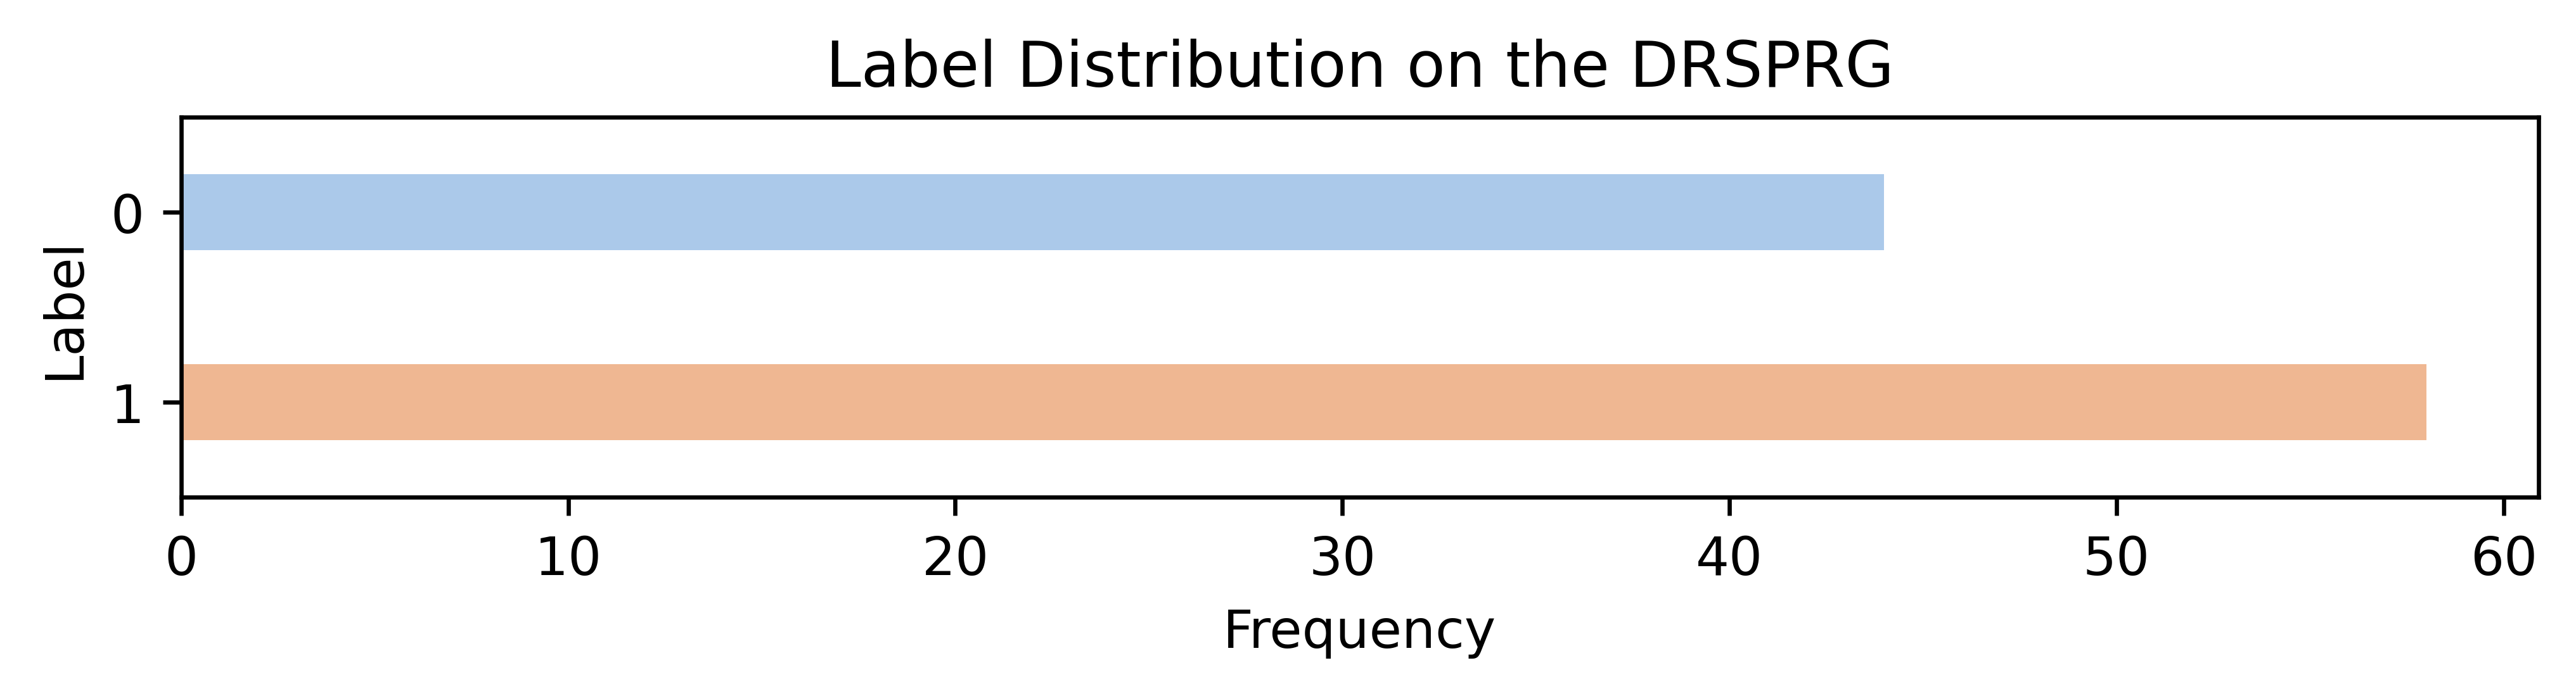

In [8]:
plt.figure(figsize=(8, 2), dpi=600)
sns.countplot(
    data=df, y="label", hue="label", width=0.4, palette="pastel", legend=False
)
plt.title(f"Label Distribution on the {DATASET_NAME.upper()}")
plt.ylabel("Label")
plt.xlabel("Frequency")
plt.gcf().subplots_adjust(top=0.80)
plt.gcf().subplots_adjust(bottom=0.30)
plt.savefig(f"../images/{DATASET_NAME.lower()}_label_dist.pdf")
plt.show()

## Grouping scintigraphy images

In [9]:
REMOVE = {
    "ANT2",
    "POST2",
    "flood",
    "POST",
    "drsprg_025",
    "drsprg_055",
    "drsprg_065",
    "drsprg_081",
    "drsprg_106",
}


def filter_images(images_dir, group_size):

    def batched(iterable, n):
        if n < 1:
            raise ValueError("n must be at least one")
        it = iter(iterable)
        while batch := tuple(islice(it, n)):
            yield batch

    def key(x):
        splited = x.name.replace(".jpg", "").split("_")
        return int(splited[-3]), int(splited[-1])

    paths = sorted(Path(images_dir).glob("**/*.jpg"))
    filtered = [
        path
        for path in paths
        if all((unwanted not in path.name) for unwanted in REMOVE)
    ]
    filtered.sort(key=key)
    yield from batched(filtered, group_size)


image_path_groups = list(filter_images(IMAGES_DIR, 12))

In [10]:
assert len(image_path_groups) / 102 == 15

## Preprocess

### Blurring

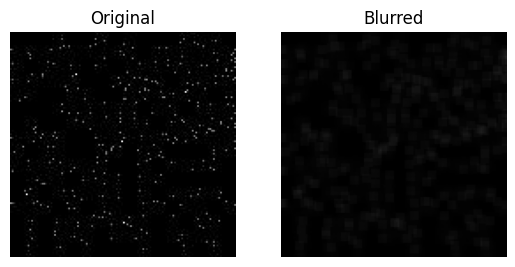

In [54]:
img = cv2.imread(str(image_path_groups[0][0]))
kernel = np.ones((5, 5), np.float32) / 25
dst = cv2.filter2D(img, -1, kernel)

fig, ax = plt.subplots(1, 2)
ax[0].set_title("Original")
ax[0].imshow(img)
ax[0].set_axis_off()
ax[1].set_title("Blurred")
ax[1].set_axis_off()
ax[1].imshow(dst)
plt.show()

In [12]:
def batched_blur(image_path_group: list) -> tuple:
    def blur(image_path: str) -> np.float32:
        img = cv2.imread(image_path)
        kernel = np.ones((5, 5), np.float32) / 25
        blurred = cv2.filter2D(img, -1, kernel)
        return blurred

    blurred_images_group = [blur(str(image_path)) for image_path in image_path_group]
    return tuple(blurred_images_group)


blurred_images_groups = [
    batched_blur(image_path_group) for image_path_group in tqdm(image_path_groups)
]

100%|██████████| 1530/1530 [00:11<00:00, 129.48it/s]


In [17]:
assert (len(blurred_images_groups) / 102) == 15.0

### Averaging

In [48]:
avg_blurred_images = []
for blurred_image_group in tqdm(blurred_images_groups):
    avg_image = np.mean(np.array(blurred_image_group).astype(np.float32), axis=0).astype(np.uint8)
    avg_blurred_images.append(avg_image)

100%|██████████| 1530/1530 [00:00<00:00, 2143.67it/s]


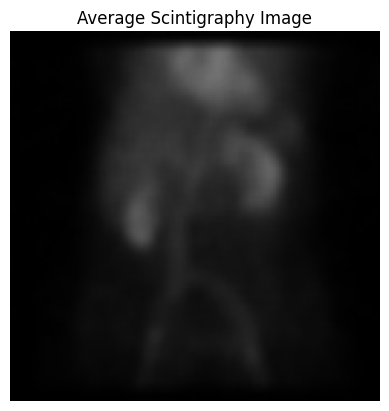

In [52]:
avg_img = avg_blurred_images[0]
plt.imshow(avg_img)
plt.title("Average Scintigraphy Image")
plt.axis("off")
plt.show()